# Carga de datos

In [2]:
# Read data_clean
import pandas as pd
import numpy as np

df = pd.read_json('./data_clean/data_clean.json', orient="records")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7565 non-null   int64  
 1   keywords               7565 non-null   object 
 2   characters             7565 non-null   object 
 3   actors                 7565 non-null   object 
 4   director               7565 non-null   object 
 5   crew                   7565 non-null   object 
 6   adult                  7565 non-null   object 
 7   belongs_to_collection  7565 non-null   object 
 8   budget                 7565 non-null   int64  
 9   genres                 7565 non-null   object 
 10  homepage               1303 non-null   object 
 11  imdb_id                7563 non-null   object 
 12  original_language      7565 non-null   object 
 13  original_title         7565 non-null   object 
 14  overview               7565 non-null   object 
 15  popu

In [3]:
def preprocess_row(row):
    # Unir las características adicionales en una sola cadena de texto
    genre = row["genres"]
    keywords = row["keywords"]
    overview = row["overview"]
    director = row["director"]
    actor = row["actors"]
    combined_text = f" {genre} [SEP] keywords: {keywords} [SEP] overview: {overview} [SEP] director: {director} [SEP] actors: {actor}"
    return combined_text

# Finetuning de BERT

In [4]:
import torch
from transformers import BertModel, BertTokenizer
import pandas as pd
import faiss
import numpy as np
from tqdm import tqdm  # Importar tqdm para la barra de progreso
import time  # Importar time para calcular el tiempo transcurrido

# Cargar modelo y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para obtener embeddings por lote
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Mover el modelo a GPU si está disponible

    # Inicializar tqdm para la barra de progreso
    pbar = tqdm(total=len(texts), desc="Processing texts", unit="texts")
    start_time = time.time()  # Tiempo de inicio del procesamiento

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        tokens = tokenizer(
            batch_texts, padding=True, truncation=True, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

        # Actualizar la barra de progreso
        pbar.update(len(batch_texts))

        # Calcular tiempo transcurrido y estimar tiempo restante
        elapsed_time = time.time() - start_time
        texts_per_sec = (i + len(batch_texts)) / elapsed_time
        remaining_time = (len(texts) - (i + len(batch_texts))) / texts_per_sec

        # Actualizar descripción de la barra de progreso con el tiempo estimado
        pbar.set_postfix({"ETA": f"{remaining_time:.1f} sec"})

    pbar.close()  # Cerrar la barra de progreso al finalizar
    return torch.cat(embeddings, dim=0).cpu().numpy() # Combina todos los embeddings en un solo tensor.

In [5]:
df['combined'] = df.apply(preprocess_row, axis=1)
combined_texts = df['combined'].tolist()

In [6]:
# Obtener embeddings
embeddings_np = get_bert_embeddings(combined_texts, batch_size=32)

Processing texts: 100%|██████████| 7565/7565 [11:17<00:00, 11.17texts/s, ETA=0.0 sec]  


Guardar embeddings y el índice en FAISS

In [7]:
np.save('./assets/embeddings.npy', embeddings_np) #array de numpy que contiene los embeddings de las películas.

d = embeddings_np.shape[1]  # Dimensiones de los embeddings
index = faiss.IndexFlatL2(d)  # Crea un índice Faiss de tipo FlatL2 con las dimensiones d
index.add(embeddings_np)  # Añade los embeddings al índice Faiss
faiss.write_index(index, './assets/embedding_index.faiss')

Recomendar Peliculas

In [8]:
# Función para obtener recomendaciones con FAISS
def get_recommendations_faiss(titles, df, index, embeddings, k=10):
    # Obtener los índices de las películas que coinciden con los títulos
    indices = [df[df['title'] == title].index[0] for title in titles]
    
    # Obtener los embeddings promedio de las películas
    avg_embedding = np.mean(embeddings[indices], axis=0, keepdims=True)
    # Buscar los k vecinos más cercanos al embedding promedio
    D, I = index.search(avg_embedding, k)
    
    # I[0][1:] contiene los índices de las películas más similares (excluyendo las ingresadas)
    movie_indices = I[0][1:]
    print(movie_indices)
    # Devolver los títulos de las películas recomendadas
    return df['title'].iloc[movie_indices].tolist()


# Ejemplo de uso
recommended_movies_faiss = get_recommendations_faiss(['Ratatouille',"Toy Story"], df, index, embeddings_np, k=15)
print(recommended_movies_faiss)


[3049  608  549 1631  579  660   96 1231    0 2857  976 2787  838 1101]
['Bee Movie', 'An American Tail', 'Doctor Dolittle', 'Finding Nemo', 'Gremlins 2: The New Batch', 'Pleasantville', 'The Flintstones', 'The Great Outdoors', 'Toy Story', 'Ratatouille', 'Return to Me', 'Open Season', 'Home Alone 2: Lost in New York', 'How the Grinch Stole Christmas']


## Metricas

 Similaridad Cosine

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular matriz de similitud coseno entre todos los pares de embeddings
similarity_matrix = cosine_similarity(embeddings_np)

 Búsqueda de Vecinos Más Cercanos con Faiss

In [10]:
# Cargar el índice Faiss
index = faiss.read_index("./assets/embedding_index.faiss")

# Realizar búsqueda de vecinos más cercanos para una película de ejemplo
query_embedding = embeddings_np[0]  # Tomar el primer embedding como ejemplo
query_embedding = query_embedding.reshape(
    1, -1
)  # Reshape para que sea compatible con Faiss

# Buscar los vecinos más cercanos
k = 5  # Número de vecinos más cercanos a buscar
distances, indices = index.search(query_embedding, k)

# Mostrar los índices de los vecinos más cercanos y sus distancias
print("Índices de vecinos más cercanos:", indices)
print("Distancias a los vecinos más cercanos:", distances)

Índices de vecinos más cercanos: [[   0   96 1884 2019  992]]
Distancias a los vecinos más cercanos: [[0.        2.7223542 3.5189714 4.0424876 4.0554495]]


Evaluación de Clasificación o Agrupamiento

In [11]:
# Ejemplo de etiquetas basadas en género (solo a modo ilustrativo)
# TODO FIX THIS S...
genres = df["genres"].to_list() 
labels = [genres.index(genre) for genre in genres]  # Convertir géneros en etiquetas numéricas

In [12]:
# Ejemplo de evaluación de clustering con K-means
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Asumiendo que tienes etiquetas conocidas en 'labels'
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings_np)
predicted_labels = kmeans.labels_

# Calcular Adjusted Rand Index entre las etiquetas predichas y las verdaderas
ari = adjusted_rand_score(labels, predicted_labels)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: 0.004938391745098623


# Explicalabilidad

## Análisis de Vecinos Más Cercanos

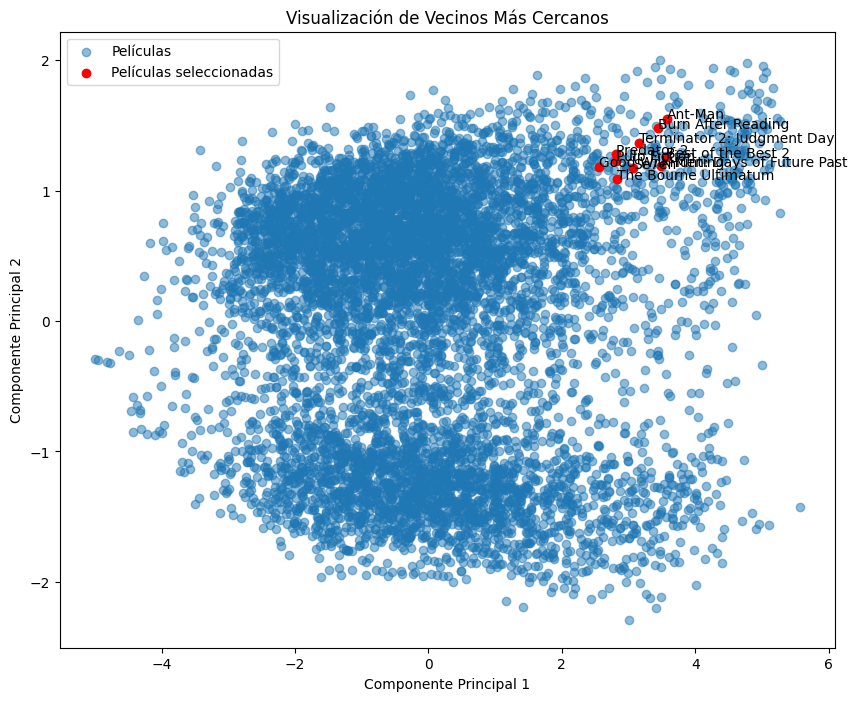

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_np)

# Visualización de los vecinos más cercanos en el espacio reducido
def plot_nearest_neighbors(movie_indices, embeddings_pca, df):
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5, label='Películas')
    plt.scatter(embeddings_pca[movie_indices, 0], embeddings_pca[movie_indices, 1], color='red', label='Películas seleccionadas')
    
    for idx in movie_indices:
        plt.annotate(df['title'].iloc[idx], (embeddings_pca[idx, 0], embeddings_pca[idx, 1]))
    
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('Visualización de Vecinos Más Cercanos')
    plt.legend()
    plt.show()

# Ejemplo de uso
titles = ['The Dark Knight', 'Inception']
indices = [df[df['title'] == title].index[0] for title in titles]

avg_embedding = np.mean(embeddings_np[indices], axis=0, keepdims=True)
D, I = index.search(avg_embedding, k=10)

plot_nearest_neighbors(I[0], embeddings_pca, df)

In [14]:
def analyze_movie_features(movie_indices, df):
    for idx in movie_indices:
        print(f"Título: {df['title'].iloc[idx]}")
        print(f"Género: {df['genres'].iloc[idx]}")
        print(f"Descripción: {df['overview'].iloc[idx]}")
        print("-" * 50)

# Ejemplo de uso
analyze_movie_features(I[0], df)


Título: Ant-Man
Género: Science Fiction, Action, Adventure
Descripción: Armed with the astonishing ability to shrink in scale but increase in strength, master thief Scott Lang must embrace his inner-hero and help his mentor, Doctor Hank Pym, protect the secret behind his spectacular Ant-Man suit from a new generation of towering threats. Against seemingly insurmountable obstacles, Pym and Lang must plan and pull off a heist that will save the world.
--------------------------------------------------
Título: Terminator 2: Judgment Day
Género: Action, Thriller, Science Fiction
Descripción: Nearly 10 years have passed since Sarah Connor was targeted for termination by a cyborg from the future. Now her son, John, the future leader of the resistance, is the target for a newer, more deadly terminator. Once again, the resistance has managed to send a protector back to attempt to save John and his mother Sarah.
--------------------------------------------------
Título: X-Men: Days of Future Pa

## Estudios de Casos y Validación Manual

In [16]:
def analyze_recommendations(titles, recommended_titles):
    for i, title in enumerate(titles):
        print(f"Para la película '{title}', las recomendaciones son:")
        print(", ".join(recommended_titles[i]))
        print("-" * 50)


# Ejemplo de uso
titles = ["The Dark Knight", "Inception"]
recommended_titles = [
    get_recommendations_faiss([title], df, index, embeddings_np) for title in titles
]

analyze_recommendations(titles, recommended_titles)

[2485 2058 2913 3170 1454 2095 4985  753 3155]
[2925 1448 2953  490 2800  148  514 2065 1551]
Para la película 'The Dark Knight', las recomendaciones son:
Batman Begins, Spider-Man 2, Spider-Man 3, The Incredible Hulk, Austin Powers in Goldmember, Resident Evil: Apocalypse, Guardians of the Galaxy, Superman, Iron Man
--------------------------------------------------
Para la película 'Inception', las recomendaciones son:
Pirates of the Caribbean: At World's End, Road to Perdition, Transformers, The Game, The Prestige, Blade Runner, Jackie Brown, Zandalee, Gangs of New York
--------------------------------------------------
